In [78]:
import cv2
import numpy as np
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

No GPU available, using CPU.


In [79]:
!ls

8.JPG  background.avi  myimage_500.jpg	myimage_n.jpg  sample_data


In [80]:
from google.colab import files
uploaded = files.upload()

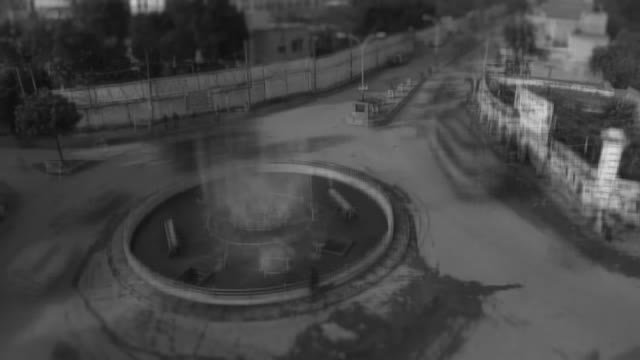

Resolution: 640x360
Video Tensor Shape: (100, 360, 640)


In [81]:
from google.colab.patches import cv2_imshow

# Read the video file
video_path = 'background.avi'
video_capture = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not video_capture.isOpened():
    print("Failed to open the video file")
    exit()


# Initialize a list to store frames
frames = []

# Read the video frame by frame
while True:
    ret, frame = video_capture.read()

    # If the frame is successfully read
    if ret:
        # Convert the frame to grayscale if desired
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Add the frame to the list
        frames.append(gray_frame)
    else:
        break

# Release the video capture
video_capture.release()

# Check if frames were successfully read
if len(frames) == 0:
    print("No frames were read from the video file")
    exit()

# Convert the list of frames to a NumPy array
video_tensor = np.array(frames)

# Get a random frame index
random_index = np.random.randint(len(video_tensor))

# Get the random grayscale frame
random_frame = video_tensor[random_index]

# Display the random grayscale frame
cv2_imshow(random_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Get the resolution of the random frame
height, width = random_frame.shape
print("Resolution: {}x{}".format(width, height))

# Print the shape of the video tensor
print("Video Tensor Shape:", video_tensor.shape)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 8.JPG to 8.JPG


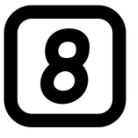

Image shape: 138 x 138


In [82]:
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

image_path = '8.JPG'
# Open the image file
image = Image.open(image_path)

# Display the image
display(image)

# Get the shape of the image
width, height = image.size

# Print the shape
print("Image shape:", width, "x", height)



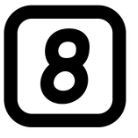

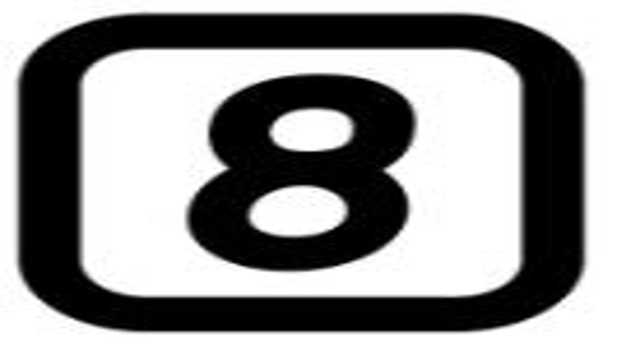

In [92]:
img = Image.open('8.JPG').convert('L')
display(img)
new_image = image.resize((640, 360))
display(new_image)

In [ ]:
!ls

8.JPG  background.avi  myimage_500.jpg	myimage_n.jpg  sample_data


In [121]:
from PIL import Image as im
import numpy as np
from scipy.fft import dct, idct
from scipy.linalg import svd
import matplotlib.pyplot as plt

def embedding(I, W, alpha):

    if I.ndim == 3:
        YCbCr = np.array(Image.fromarray(I).convert('YCbCr'))
    else:
        YCbCr = np.expand_dims(I, axis=2)
    IY = YCbCr[:, :, 0]
    N = max(IY.shape)
    NIY = np.array(Image.fromarray(IY).resize((N, N)))

    blk = np.zeros((16, 16))
    dcCoef = np.zeros((N // 16, N // 16))


    u = 0
    v = 0
    TDC = np.zeros((N, N))
    for i in range(0, N, 16):
        for j in range(0, N, 16):
            blk = NIY[i:i+16, j:j+16]
            T = dct(dct(blk.T, norm='ortho').T, norm='ortho')
            TDC[i:i+16, j:j+16] = T
            dcCoef[u, v] = T[0, 0]
            v += 1
        v = 0
        u += 1

    udc, sdc, vdc = svd(dcCoef)
    W = np.array(Image.fromarray(W).resize((N // 16, N // 16)))
    uw, sw, vw = svd(W.astype(float))
    S = sdc + alpha * sw
    M = udc @ (np.diag(S) @ vdc)
    u = 0
    v = 0
    G = np.zeros((N, N))
    for i in range(0, N, 16):
        for j in range(0, N, 16):
            blk = TDC[i:i+16, j:j+16]
            blk[0, 0] = M[u, v]
            G[i:i+16, j:j+16] = idct(idct(blk.T, norm='ortho').T, norm='ortho')
            v += 1
        v = 0
        u += 1


    if I.ndim == 3:
        y = np.zeros_like(YCbCr)
        y[:, :, 0] = G.astype(np.uint8)
        y[:, :, 1:] = YCbCr[:, :, 1:]
        r = np.array(Image.fromarray(y, 'YCbCr').convert('RGB'))
    else:
        r = G.astype(np.uint8)

    return r



alpha = 1.5
watermarked_frames = []

# Iterate over each frame in video_tensor
for frame in video_tensor:
    # Convert the frame to PIL Image
    data = Image.fromarray(frame)

    # Convert the watermark image to numpy array
    new_image = np.array(new_image)

    # Apply watermark embedding
    data = np.array(data)
    watermarked_image = embedding(data, new_image, alpha)

    # Resize the watermarked image to 640x360
    watermarked_image = Image.fromarray(watermarked_image).resize((640, 360))

    # Convert the resized image back to numpy array
    watermarked_image = np.array(watermarked_image)


    # Append the watermarked frame to the list
    watermarked_frames.append(watermarked_image)

# Convert the watermarked frames back to a numpy array
watermarked_video = np.array(watermarked_frames)




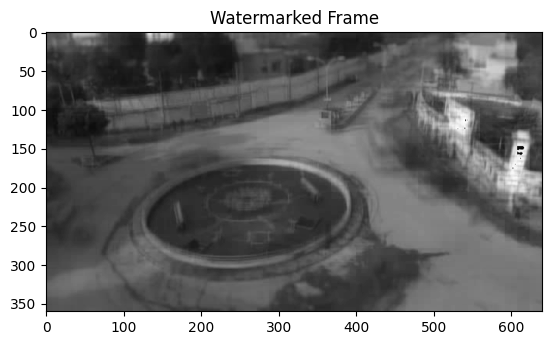

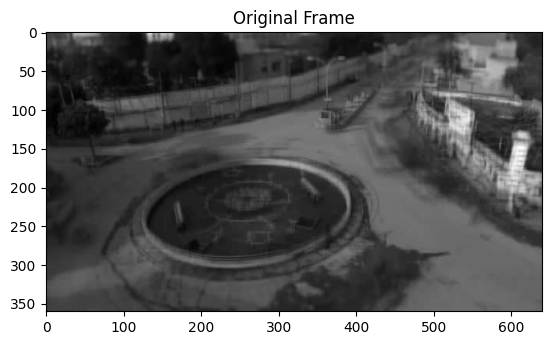

In [122]:
# Display one frame from watermarked_frames
watermarked_frame = watermarked_frames[0]
plt.imshow(watermarked_frame, cmap='gray')
plt.title('Watermarked Frame')
plt.show()

# Display one frame from video_tensor
original_frame = video_tensor[0]
plt.imshow(original_frame, cmap='gray')
plt.title('Original Frame')
plt.show()

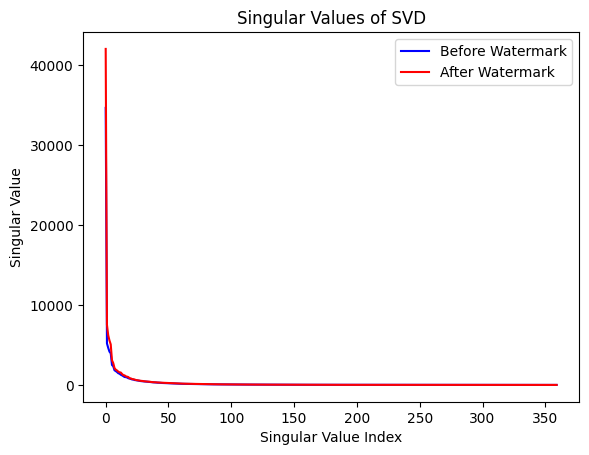

In [123]:
import numpy as np
import matplotlib.pyplot as plt



# Select one frame from video_tensor
original_frame = video_tensor[0]

# Perform SVD on the original frame
U, S, V = np.linalg.svd(original_frame)

# Plot the singular values before watermark embedding
plt.plot(S, 'b', label='Before Watermark')

# Select the corresponding watermarked frame
watermarked_frame = watermarked_frames[0]

# Perform SVD on the watermarked frame
U_watermarked, S_watermarked, V_watermarked = np.linalg.svd(watermarked_frame)

# Plot the singular values after watermark embedding
plt.plot(S_watermarked, 'r', label='After Watermark')

plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of SVD')
plt.legend()
plt.show()

In [129]:
extracted_frames = []

for watermarked_frame in watermarked_frames:
    # Convert the watermarked frame to PIL Image
    watermarked_data = Image.fromarray(watermarked_frame)

    # Apply the same watermark embedding function to extract the watermark
    watermarked_data = np.array(watermarked_data)
    extracted_image = embedding(watermarked_data, np.zeros_like(new_image), -alpha)

    # Resize the extracted image to the original size
    extracted_image = Image.fromarray(extracted_image).resize((640, 360))

    # Convert the resized image back to numpy array
    extracted_frame = np.array(extracted_image)

    # Append the extracted frame to the list
    extracted_frames.append(extracted_frame)

# Convert the extracted frames back to a numpy array
extracted_video = np.array(extracted_frames)

In [131]:
def apply_blur_filter(image, kernel_size):
    # Define the blur kernel
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)

    # Check the number of channels in the image
    if len(image.shape) == 2:  # Grayscale image
        blurred_image = np.convolve(image.flatten(), kernel.flatten(), mode='same').reshape(image.shape)
    elif len(image.shape) == 3:  # RGB image
        blurred_image = np.zeros_like(image, dtype=np.float32)
        for channel in range(image.shape[2]):
            blurred_image[:, :, channel] = np.convolve(image[:, :, channel].flatten(), kernel.flatten(), mode='same').reshape(image.shape[:2])

    return blurred_image.astype(np.uint8)

blurred_frames = []

# Iterate over each frame in the watermarked video
for frame in watermarked_video:
    # Apply the blur filter with a kernel size of 5x5
    blurred_frame = apply_blur_filter(frame, kernel_size=5)

    # Append the blurred frame to the list
    blurred_frames.append(blurred_frame)

# Convert the blurred frames back to a numpy array
blurred_video = np.array(blurred_frames)

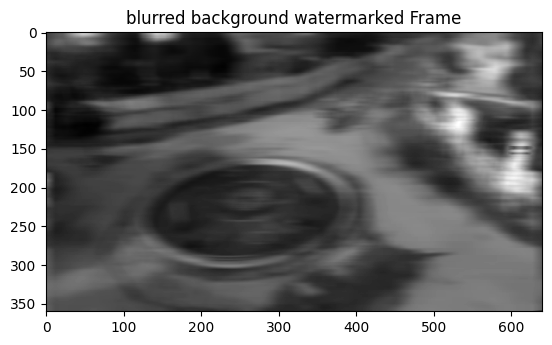

In [136]:
# Display one frame from watermarked_frames
frame = blurred_video[0]
plt.imshow(frame, cmap='gray')
plt.title('blurred background watermarked Frame')
plt.show()

In [137]:
def create_video_from_images(images, output_filename):
    """Generate a video from the list of images."""
    first_image = images[0]
    h, w = first_image.shape[:2]  # Retrieve height and width only

    codec = cv2.VideoWriter_fourcc(*'MJPG')  # Use MJPG codec for AVI format
    vid_writer = cv2.VideoWriter(output_filename, codec, 20, (w, h), isColor=False)  # Set isColor=False for grayscale images

    for img in images:
        vid_writer.write(img)

    vid_writer.release()
def resize_images_to_average(images, avg_width, avg_height):
    """Resize all images in the list to the provided average dimensions."""
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, (avg_width, avg_height), interpolation=cv2.INTER_AREA)
        resized_images.append(resized_img)
    return resized_images

# Example usage
images = blurred_video
avg_width = 640
avg_height = 360

# Resize images to average dimensions
resized_images = resize_images_to_average(images, avg_width, avg_height)

# Create video from resized images
create_video_from_images(resized_images, 'blurreded-background-watermarked.avi')



In [138]:
from google.colab import files

# Download the animation file
files.download('blurreded-background-watermarked.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>